In [1]:
!pip install PyPortfolioOpt

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns

# APT
**1. Inputs**
- Creating the inputs, fetching historical data from assets, macroeconomic data

In [3]:
# This block generates a df for all the asset returns on a quarterly, adjusted basis
##User input for our asset tickers
tickers = 'BYD DRIV IE000MCVFK47 KC=F'
df1 = yf.download(tickers=tickers, start='2014-01-01', end='2023-12-31', interval='1d')

# Select Adjusted Close and resample to quarterly frequency
df1 = df1['Close']  # Select 'Adj Close' column directly
df1 = df1.resample('QE').last()  # Resample to quarterly frequency

# Calculate quarterly returns
asset_returns_df = df1.pct_change().dropna()  # Calculate percentage change and drop nil values
asset_returns_df

[*********************100%***********************]  4 of 4 completed


Ticker,BYD,DRIV,IE000MCVFK47,KC=F
Date,,,,
2021-09-30,0.028785,-0.031438,0.001037,0.217446
2021-12-31,0.036516,0.113421,-0.004343,0.165464
2022-03-31,0.003203,-0.097281,-0.064327,0.001327
2022-06-30,-0.243691,-0.220972,-0.081376,0.031802
2022-09-30,-0.042211,-0.062878,-0.033204,-0.051584
2022-12-31,0.144386,-0.012425,0.006199,-0.244866
2023-03-31,0.175867,0.199799,0.014992,0.019127
2023-06-30,0.081878,0.092282,0.003035,-0.055718
2023-09-30,-0.123108,-0.097926,-0.003591,-0.092236


In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# User Input for our macro indicators
date1 = '2014-01-01'
date2 = '2023-12-31'
factors = {
    "URATEUS": "/content/drive/My Drive/EconDB/URATEUS.csv",
    "CPIUK": "/content/drive/My Drive/EconDB/CPIUK.csv",
    "RGDPIN": "/content/drive/My Drive/EconDB/RGDPIN.csv",
    "GSPECN": "/content/drive/My Drive/EconDB/GSPECN.csv",

}

# Create an empty dictionary to store the data
data = {}

# Fetch the data for each indicator factor
for name, filepath in factors.items():
    df2 = pd.read_csv(filepath)
    df2.columns = ['Date', name]  # Rename columns to 'Date' and the factor name
    df2['Date'] = pd.to_datetime(df2['Date'])  # Ensure 'Date' column is in datetime format
    data[name] = df2

# Function to manually resample data to quarterly without using pandas resample
def manual_resample_to_quarterly(df):
    quarterly_data = []

    for _, row in df.iterrows():
        year, month = row['Date'].year, row['Date'].month

        # Map months to quarters
        if month in [1, 2, 3]:
            quarter = f"{year}-Q1"
        elif month in [4, 5, 6]:
            quarter = f"{year}-Q2"
        elif month in [7, 8, 9]:
            quarter = f"{year}-Q3"
        else:
            quarter = f"{year}-Q4"

        quarterly_data.append((quarter, row[1]))

    # Aggregate data by quarter
    quarterly_df = {}
    for quarter, value in quarterly_data:
        if quarter not in quarterly_df:
            quarterly_df[quarter] = []
        quarterly_df[quarter].append(value)

    # Take mean for each quarter
    result = {quarter: sum(values) / len(values) for quarter, values in quarterly_df.items()}

    return result

# Process each dataset and resample to quarterly
data_resampled = {}
for name, df in data.items():
    data_resampled[name] = manual_resample_to_quarterly(df)

# Combine all resampled data
from collections import defaultdict
combined_data = defaultdict(dict)
for name, resampled in data_resampled.items():
    for quarter, value in resampled.items():
        combined_data[quarter][name] = value

# Convert to DataFrame
import pandas as pd
final_df = pd.DataFrame.from_dict(combined_data, orient='index').sort_index()

# Filter only the dates required
final_df.index = pd.PeriodIndex(final_df.index, freq='Q')
final_df = final_df[(final_df.index >= date1) & (final_df.index <= date2)]

# Calculate quarterly returns
factors_returns_df = final_df.pct_change().dropna()

factors_returns_df


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-4-edfb5d1e537b>:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quarterly_data.append((quarter, row[1]))
<ipython-input-4-edfb5d1e537b>:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quarterly_data.append((quarter, row[1]))
<ipython-input-4-edfb5d1e537b>:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quarterly_data.append((quarter, row[1]))
<ipython-input-4-edfb5d1e537b>:43: FutureWarning: Series.__getitem__ t

,URATEUS,CPIUK,GSPECN,RGDPIN
2014Q2,-0.070000,0.007042,1.803511,-0.024298
2014Q3,-0.021505,0.000333,0.686985,0.010447
2014Q4,-0.060440,0.000666,0.435903,0.032669
2015Q1,-0.029240,-0.006986,-0.847218,0.052074
2015Q2,-0.018072,0.005695,2.027768,-0.019921
2015Q3,-0.061350,0.000999,0.731233,0.014591
2015Q4,-0.013072,0.001331,0.467547,0.024674
2016Q1,-0.026490,-0.004653,-0.849478,0.070636
2016Q2,0.006803,0.005676,1.985201,-0.023594
2016Q3,-0.006757,0.004648,0.712165,0.023833


In [5]:
print(factors_returns_df.index)
print(asset_returns_df.index)


# Ensure both indices are in the same format (DatetimeIndex with quarter-end dates)
factors_returns_df.index = factors_returns_df.index.to_timestamp('Q', 'end')  # Convert PeriodIndex to DatetimeIndex
asset_returns_df.index = asset_returns_df.index.to_period('Q').to_timestamp('Q', 'end')  # Ensure quarter-end alignment

# Align dates between factors and asset returns
aligned_index = factors_returns_df.index.intersection(asset_returns_df.index)
factors_returns_aligned = factors_returns_df.loc[aligned_index]
asset_returns_aligned = asset_returns_df.loc[aligned_index]

# Display aligned DataFrames
factors_returns_aligned, asset_returns_aligned


PeriodIndex(['2014Q2', '2014Q3', '2014Q4', '2015Q1', '2015Q2', '2015Q3',
             '2015Q4', '2016Q1', '2016Q2', '2016Q3', '2016Q4', '2017Q1',
             '2017Q2', '2017Q3', '2017Q4', '2018Q1', '2018Q2', '2018Q3',
             '2018Q4', '2019Q1', '2019Q2', '2019Q3', '2019Q4', '2020Q1',
             '2020Q2', '2020Q3', '2020Q4', '2021Q1', '2021Q2', '2021Q3',
             '2021Q4', '2022Q1', '2022Q2', '2022Q3', '2022Q4', '2023Q1',
             '2023Q2', '2023Q3', '2023Q4'],
            dtype='period[Q-DEC]')
DatetimeIndex(['2021-09-30', '2021-12-31', '2022-03-31', '2022-06-30',
               '2022-09-30', '2022-12-31', '2023-03-31', '2023-06-30',
               '2023-09-30', '2023-12-31'],
              dtype='datetime64[ns]', name='Date', freq='QE-DEC')


(                                URATEUS     CPIUK    GSPECN    RGDPIN
 2021-09-30 23:59:59.999999999 -0.146067  0.010837  0.620547  0.096011
 2021-12-31 23:59:59.999999999 -0.177632  0.022037  0.384296  0.053825
 2022-03-31 23:59:59.999999999 -0.088000  0.013403 -0.766556  0.066784
 2022-06-30 23:59:59.999999999 -0.043860  0.042553  1.022505 -0.084440
 2022-09-30 23:59:59.999999999 -0.027523  0.018753  0.626258  0.024578
 2022-12-31 23:59:59.999999999  0.009434  0.028966  0.381992  0.041838
 2023-03-31 23:59:59.999999999 -0.018692  0.008156 -0.764880  0.086455
 2023-06-30 23:59:59.999999999  0.019048  0.026096  0.991992 -0.066665
 2023-09-30 23:59:59.999999999  0.037383  0.002543  0.602125  0.023047
 2023-12-31 23:59:59.999999999  0.009009  0.004313  0.399054  0.046561,
 Ticker                              BYD      DRIV  IE000MCVFK47      KC=F
 2021-09-30 23:59:59.999999999  0.028785 -0.031438      0.001037  0.217446
 2021-12-31 23:59:59.999999999  0.036516  0.113421     -0.004343  0.

In [6]:
#This block aligns the two df (asset, and factor returns) into two matrices
common_index = asset_returns_df.index.intersection(factors_returns_df.index) #Finds the list of shared dates between the two matrices

#Then filters only the data with overlapping dates, keep
aligned_asset_returns = asset_returns_df.loc[common_index]
aligned_factors_returns = factors_returns_df.loc[common_index]

# Convert to matrices for further processing
aligned_asset_matrix = aligned_asset_returns.values
aligned_factors_matrix = aligned_factors_returns.values

# Verify alignment and output
print("Aligned Asset Returns Matrix Shape:", aligned_asset_matrix.shape)
print("Aligned Factor Returns Matrix Shape:", aligned_factors_matrix.shape)

print("\nAligned Asset Returns Matrix:")
print(aligned_asset_matrix)
print("\nAligned Indicator Matrix:")
print(aligned_factors_matrix)


Aligned Asset Returns Matrix Shape: (10, 4)
Aligned Factor Returns Matrix Shape: (10, 4)

Aligned Asset Returns Matrix:
[[ 0.02878511 -0.03143763  0.00103719  0.21744583]
 [ 0.03651599  0.11342088 -0.00434273  0.16546395]
 [ 0.00320267 -0.0972814  -0.06432672  0.00132679]
 [-0.24369108 -0.22097243 -0.08137568  0.03180217]
 [-0.04221102 -0.06287837 -0.03320419 -0.05158392]
 [ 0.14438609 -0.01242545  0.00619944 -0.24486572]
 [ 0.17586657  0.19979865  0.01499219  0.0191273 ]
 [ 0.08187773  0.09228191  0.00303504 -0.05571848]
 [-0.12310798 -0.09792631 -0.00359069 -0.09223606]
 [ 0.02926186  0.05023416  0.06025019  0.2884024 ]]

Aligned Indicator Matrix:
[[-0.14606742  0.01083685  0.62054694  0.09601132]
 [-0.17763158  0.02203693  0.38429554  0.05382528]
 [-0.088       0.01340326 -0.76655554  0.06678418]
 [-0.04385965  0.04255319  1.02250509 -0.08443989]
 [-0.02752294  0.01875345  0.62625818  0.02457808]
 [ 0.00943396  0.02896589  0.38199185  0.04183784]
 [-0.01869159  0.00815575 -0.7648804

**2. APT Regression**

In [7]:
#This block implements linear regression based on the APT formula to calculate the systematic (alpha and beta) and idiosyncractic risk factors
import numpy as np
from sklearn.linear_model import LinearRegression

factors_count = factor_count = len(factors)
assets_count = len(tickers.split())

n_factors = factors_count
n_assets = assets_count  # Number of assets

# Placeholder for results
alphas = []
betas = []
residuals = []

# performing linear regression to determine alpha, beta, and epsilon for each asset
for i in range(n_assets):
    model = LinearRegression()
    model.fit(aligned_factors_matrix, aligned_asset_matrix[:, i])  # Regress asset returns on factors

    alpha = model.intercept_  # Intercept (alpha)
    beta = model.coef_  # Factor loadings (betas)
    #calculating residuals (epsilon) below
    predicted_returns = model.predict(aligned_factors_matrix)
    residual = aligned_asset_matrix[:, i] - predicted_returns

    alphas.append(alpha)
    betas.append(beta)
    residuals.append(residual)

# Variance of residuals (idiosyncratic risk)
idiosyncratic_variances = [np.var(residual) for residual in residuals]

# Display results
print("Alphas (Intercepts):", alphas)
print("\nBetas (Factor Loadings):", np.array(betas))
print("\nIdiosyncratic Variances:", idiosyncratic_variances)

Alphas (Intercepts): [-0.0911075386808313, 0.01401559626667437, -0.011244774518986205, 0.1682787110831309]

Betas (Factor Loadings): [[  0.74388758   4.66338304  -0.02300159   1.98436884]
 [  0.09871556  -1.12161484  -0.03025172   0.48564401]
 [  0.24950048  -0.81824208   0.03382722   0.5024222 ]
 [ -1.79707708 -10.65096823   0.03536174  -1.39671176]]

Idiosyncratic Variances: [0.007627680449577137, 0.011094770176684251, 0.000679751866568936, 0.00996518157467058]


In [8]:
#This block takes the input from APT then converts to covariance matrix of assets
# Convert betas to a matrix
B = np.array(betas)  # Factor loadings matrix (n_assets x n_factors)

# Variance of residuals (idiosyncratic risk)
idiosyncratic_variances = [np.var(residual) for residual in residuals]
Sigma_epsilon = np.diag(idiosyncratic_variances)  # Diagonal matrix of idiosyncratic variances

# Compute factor covariance matrix (Sigma_F)
Sigma_F = np.cov(aligned_factors_matrix, rowvar=False)  # Covariance of factor returns

# Calculate total covariance matrix
# Covariance matrix = B * Sigma_F * B.T + Sigma_epsilon
covariance_matrix = B @ Sigma_F @ B.T + Sigma_epsilon

# Display results
print("Alphas (Intercepts):", alphas)
print("\nBetas (Factor Loadings):", B)
print("\nIdiosyncratic Variances:", idiosyncratic_variances)
print("\nTotal Covariance Matrix:")
print(covariance_matrix)


Alphas (Intercepts): [-0.0911075386808313, 0.01401559626667437, -0.011244774518986205, 0.1682787110831309]

Betas (Factor Loadings): [[  0.74388758   4.66338304  -0.02300159   1.98436884]
 [  0.09871556  -1.12161484  -0.03025172   0.48564401]
 [  0.24950048  -0.81824208   0.03382722   0.5024222 ]
 [ -1.79707708 -10.65096823   0.03536174  -1.39671176]]

Idiosyncratic Variances: [0.007627680449577137, 0.011094770176684251, 0.000679751866568936, 0.00996518157467058]

Total Covariance Matrix:
[[ 0.01437532  0.00359544  0.00111684 -0.00216206]
 [ 0.00359544  0.01391728  0.00087752  0.00147264]
 [ 0.00111684  0.00087752  0.0015657   0.00038768]
 [-0.00216206  0.00147264  0.00038768  0.02396552]]


In [9]:
# This block calculates the expected asset returns from APT inputs
expected_factor_returns = np.mean(aligned_factors_matrix, axis=0)
expected_asset_returns = alphas + np.dot(B, expected_factor_returns)

# Display results
print("\nExpected asset returns:")
print(expected_asset_returns)


Expected asset returns:
[ 0.00908859 -0.0067186  -0.0101326   0.02791643]


# Black-Litterman Optimization
**1. Inputs**
- Creating the inputs, fetching historical data from assets, macroeconomic data

**1. Priors**
- Inputting data and creating market implied market returns


In [10]:
# Example matrices (replace these with your actual matrices)
# Covariance matrix columns/rows represent the assets
# Initialize an empty dictionary to store market caps

assets = tickers.split()
expected_returns = expected_asset_returns  # Replace with your own data

cov_matrix = pd.DataFrame(covariance_matrix)
print(cov_matrix)
cov_matrix.reset_index(drop=True)
cov_matrix.index = assets        # Set row index to assets
cov_matrix.columns = assets      # Set column index to assets


# Hardcoded dictionary with tickers and their market caps
market_caps = {
    'BYD': 102343000000,
    'DRIV': 52300000000,
    'IE000MCVFK47': 12400000000,
    'KC=F': 7500000000
}

market_caps

# Market-implied risk aversion parameter (using a risk-free rate of 0.02)
spy_data = yf.download("SPY", start="2020-01-01", end="2025-01-01")
market_prices = spy_data["Close"]
risk_free_rate = 0.02
delta = black_litterman.market_implied_risk_aversion(market_prices, risk_free_rate=risk_free_rate)

# Compute the market-implied prior returns
market_prior = black_litterman.market_implied_prior_returns(market_caps, delta, cov_matrix)


          0         1         2         3
0  0.014375  0.003595  0.001117 -0.002162
1  0.003595  0.013917  0.000878  0.001473
2  0.001117  0.000878  0.001566  0.000388
3 -0.002162  0.001473  0.000388  0.023966


[*********************100%***********************]  1 of 1 completed


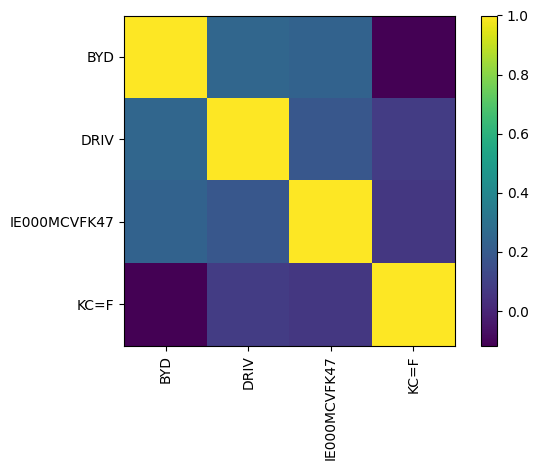

In [11]:
plotting.plot_covariance(cov_matrix, plot_correlation=True);


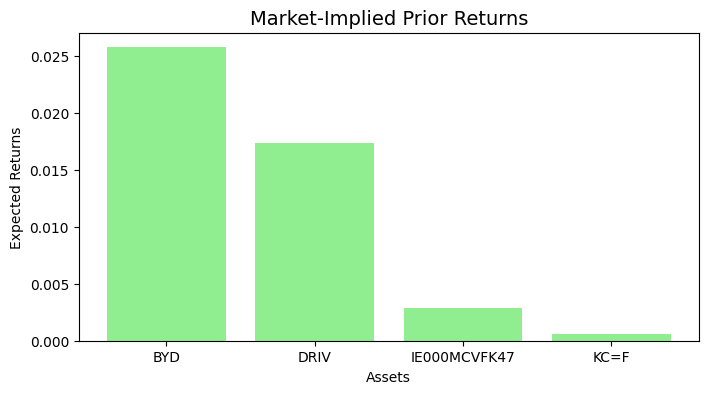

In [12]:
# Visualize Market-Implied Prior Returns
plt.figure(figsize=(8, 4))
plt.title("Market-Implied Prior Returns", fontsize=14)
plt.bar(market_caps.keys(), market_prior, color='lightgreen')
plt.ylabel("Expected Returns")
plt.xlabel("Assets")
plt.show()

**2. Views**
- Combine our subjective macroeconomic analysis views into the model, either absolute or relative

In [13]:
# Example: Absolute view that Asset 1 will return 6%, and relative view that Asset 2 will outperform Asset 3 by 2%
absolute_views = {
    "BYD": 0.06,
    "DRIV": 0.09,
    "IE000MCVFK47": 0.16,
}


# Define the picking matrix (P) and views vector (Q)
P = np.array([
    [1, -1, 0, 0],  # View 1: A outperforms B by 3%
    [0, 0, -1, 1]   # View 2: D outperforms C by 1%
])

Q = np.array([
    0.03,  # Expected outperformance of A over B
    -0.01  # Expected underperformance of C relative to D
])

relative_views = {"BYD": 0.02, "DRIV": -0.02}  # Example relative views (optional)

# Create Black-Litterman model instance
bl = BlackLittermanModel(
    cov_matrix=cov_matrix,
    pi=market_prior,
    absolute_views=absolute_views
)

# Calculate the posterior returns and covariance matrix
posterior_returns = bl.bl_returns()
posterior_cov = bl.bl_cov()

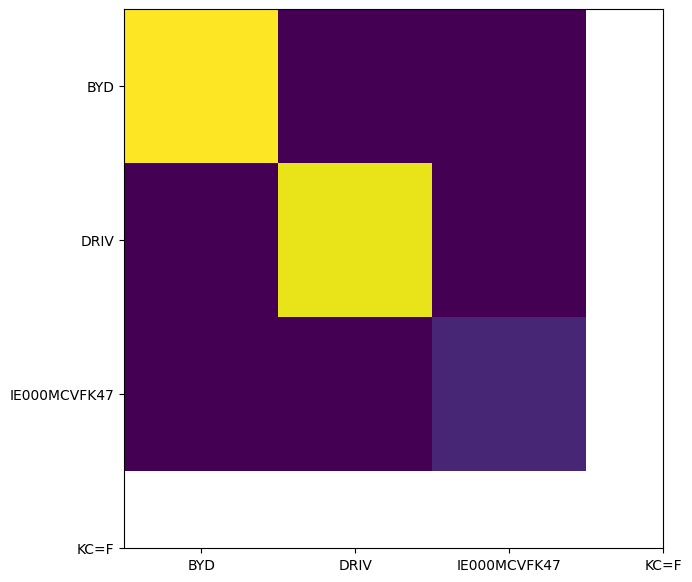

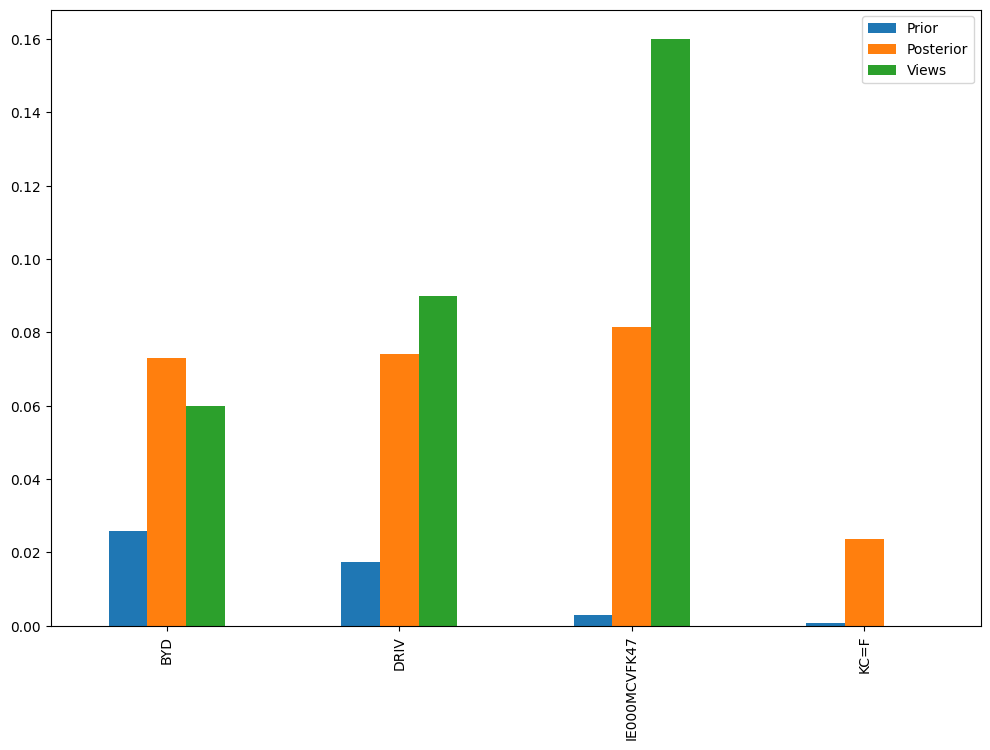

In [14]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

rets_df = pd.DataFrame([market_prior, posterior_returns, pd.Series(absolute_views)],
             index=["Prior", "Posterior", "Views"]).T
rets_df

rets_df.plot.bar(figsize=(12,8));

**3. Optimization**
- Optimization with efficient frontier

In [15]:
# Calculate the posterior returns and covariance matrix
posterior_returns = bl.bl_returns()
posterior_cov = bl.bl_cov()

# Optimize the portfolio using Efficient Frontier
ef = EfficientFrontier(posterior_returns, posterior_cov)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()



Optimized Portfolio Weights: OrderedDict([('BYD', 0.0139), ('DRIV', 0.03743), ('IE000MCVFK47', 0.94654), ('KC=F', 0.00214)])
Expected annual return: 8.1%
Annual volatility: 3.9%
Sharpe Ratio: 2.05


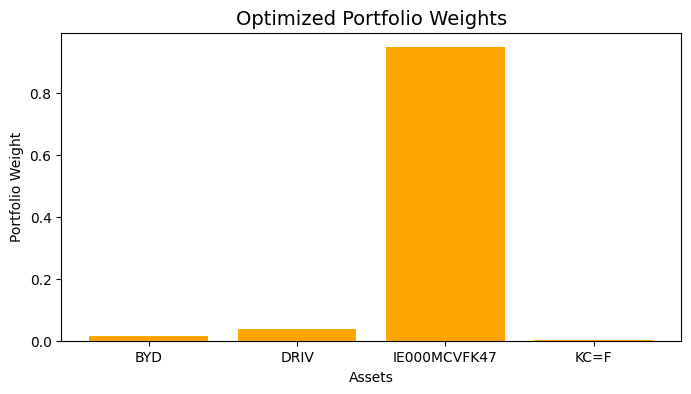

In [16]:
# Display the portfolio weights and performance
print("Optimized Portfolio Weights:", cleaned_weights)
performance = ef.portfolio_performance(verbose=True)

# Visualize Optimized Portfolio Weights
plt.figure(figsize=(8, 4))
plt.title("Optimized Portfolio Weights", fontsize=14)
plt.bar(cleaned_weights.keys(), cleaned_weights.values(), color='orange')
plt.ylabel("Portfolio Weight")
plt.xlabel("Assets")
plt.show()